# SETUP

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import torch
from tqdm import tqdm, trange
from transformers import AutoModel
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.


In [2]:
# GPU check
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


# FUNCTIONS

In [3]:
"""
For dealing with large amounts of data, a GPU is much faster

The resulting embedding matrix is a three-dimensional tensor corresponding to                 [Sentence][Words][Embeddings]
embeddings[5][4][:] is thus the embedding of the fourth word in the fifth sentence
"""

def get_embeddings_with_gpu(data_matrix, mask_matrix):
    # Load the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Set the model to use the device
    model.cuda()

    # Move the data onto the GPU
    data_matrix = data_matrix.to(device)
    mask_matrix = mask_matrix.to(device)

    # Generate embeddings
    matrix_embedding = model.forward(input_ids=data_matrix,
        attention_mask=mask_matrix,
        head_mask=None)[0]
    #print(f"Embedding generated with shape {batch_embedding.shape}")

    # Make it an ordinary np array instead of a torch
    matrix_embedding = np.array(matrix_embedding.tolist())

    return matrix_embedding

#Keep amount of samples low to not overwhelm the gpu
#get_embeddings_with_gpu(data_tensor_matrix[:10], mask_tensor_matrix[:10])

In [4]:
"""
Most people won't be able to load all the data onto the GPU at once however, so it's better   to do it in batches.
(50 input sentences take 2803MB on my computer, for example). Though this depends on the dimensionality/sentence_length you use, naturally

This method batchifies and stitches together the batches
"""
def get_embeddings_with_gpu_batch(data_matrix, mask_matrix, batch_size):
    num_items = data_matrix.shape[0]
    num_loops = int(np.ceil(num_items/batch_size))

    start = 0
    end = batch_size
    data_holder = []

    for i in trange(num_loops):
        # Split the data into batches
        data_batch = data_matrix[start:end]
        mask_batch = mask_matrix[start:end]

        #Get the embedding for the batch
        batch_embedding = get_embeddings_with_gpu(data_batch, mask_batch)

        data_holder.append(batch_embedding)

        #Move to next batch
        start += batch_size
        end += batch_size

    # Merge the batches we've generated
    embedding_matrix = np.vstack(data_holder)

    print(f"Final embedding generated with shape {embedding_matrix.shape}")

    return embedding_matrix

#embedding_matrix = get_embeddings_with_gpu_batch(data_tensor_matrix[:200], mask_tensor_matrix[:200], 50)


In [5]:
"""
Split data into train and test sets by the given ratio.
Validation sets are not needed, those we get for free with keras models

"""
def split_data(percentage_to_train_on, input_data, output_data):
    ratio = percentage_to_train_on

    split = int(np.ceil(ratio*input_data.shape[0]))

    train_x = input_data[:split]
    train_y = output_data[:split]

    test_x = input_data[split:]
    test_y = output_data[split:]

    return train_x, train_y, test_x, test_y


def shuffle_data(things_to_shuffle):
    """
    Takes a list of lists and shuffles them all in the same way
    """
    #Set seed for reproducibility
    random.seed(2020)
    
    # Create a list of indices based on the input data
    indices = [i for i in range(things_to_shuffle[0].shape[0])]

    #Shuffle the indices
    random.shuffle(indices)

    shuffled_lists = []
    #For each list,
    for thing_to_shuffle in things_to_shuffle:
        #Reorder the list according to the shuffled indices
        shuffled = np.array([thing_to_shuffle[i] for i in indices])
        shuffled_lists.append(shuffled)
    return shuffled_lists

# LOAD DATA

In [6]:
#This is the latest!
def load_data_from_start2():
    #Load the data
    sentences = np.load("../data/sentence_ints.npy")
    attentions = np.load("../data/attention_ints.npy")
    labels = np.load("../data/label_ints.npy")
    label_list = np.load("../data/label_list.npy")
    return sentences, attentions, labels, label_list

sentences, attentions, labels, label_list = load_data_from_start2()


In [7]:
#Shuffle the data
shuffled = shuffle_data([sentences, attentions, labels])
sentences, attentions, labels = shuffled[0], shuffled[1], shuffled[2]

In [8]:
# Load the model and tokenizer
model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(label_list.tolist())

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(50030, 128)

In [9]:
def work_with_subset(subsetsize):
    # Let's test stuff with just a subset of the data
    s, a, l = sentences[:subsetsize], attentions[:subsetsize], labels[:subsetsize]

    #Convert to tensors
    s, a = torch.tensor(s), torch.tensor(a)
    
    # Generate embeddings
    #embedding_matrix = get_embeddings_with_gpu_batch(s, a, 25)
    
    return s, a, l, 1
    
sentences, attentions, labels, _ = work_with_subset(10000)

In [10]:
def generate_embedding_file(sentences, attentions):
    """
    I can't keep the full embedding matrix in RAM, so I'll store it on disk instead using memap
    """
    #CREATE MEMORY-MAPPED-OBJECT
    
    #This is given by the model we are using
    token_embedding_dim = 768

    #Define the shape of the matrix that will hold the full embedding matrix
    embeddiding_matrix_shape= (sentences.shape[0], sentences.shape[1], token_embedding_dim)

    #Select the type of the data we will store.
    data_type = np.float64

    #Make space for it on disk
    f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type,
                  mode='w+', shape=embeddiding_matrix_shape)


    #GENERATE EMBEDDINGS AND STORE IN OBJECT
    #Convert to tensors
    sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)
    
    num_batches = 11
    batch_size = int(np.ceil(sentences.shape[0]/num_batches))
    for i in range(0, num_batches):
        #Define slice to generate embedding for
        start = batch_size * i
        end = batch_size * (i+1)
        
        #Generate the batch
        sentence_batch = sentences[batch_size * i : batch_size * (i + 1)]
        attention_batch = attentions[batch_size * i : batch_size * (i + 1)]
                
        # store it in the memmap object
        #Do it directly, if you save it as a reference the memory will still run out during the for loop
        f[start:end, :, :] = get_embeddings_with_gpu_batch(sentence_batch, attention_batch, 25)
        print(f"Stored sentence embedding {start} to {end}")

        

generate_embedding_file(sentences, attentions)


/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 37/37 [00:25<00:00,  1.47it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 0 to 910


100%|██████████| 37/37 [00:24<00:00,  1.50it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 910 to 1820


100%|██████████| 37/37 [00:20<00:00,  1.81it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 1820 to 2730


100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 2730 to 3640


100%|██████████| 37/37 [00:15<00:00,  2.40it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 3640 to 4550


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 4550 to 5460


100%|██████████| 37/37 [00:15<00:00,  2.36it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 5460 to 6370


100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 6370 to 7280


100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/37 [00:00<?, ?it/s]

Stored sentence embedding 7280 to 8190


100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


Final embedding generated with shape (910, 100, 768)


  0%|          | 0/36 [00:00<?, ?it/s]

Stored sentence embedding 8190 to 9100


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


Final embedding generated with shape (900, 100, 768)
Stored sentence embedding 9100 to 10010


In [33]:
token_embedding_dim = 768

#Define the shape of the matrix that will hold the full embedding matrix
embeddiding_matrix_shape= (sentences.shape[0], sentences.shape[1], token_embedding_dim)

#Select the type of the data we will store.
data_type = np.float64
f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type, shape=embeddiding_matrix_shape)

In [11]:
#We need to one-hot encode the output labels for use with the classifier

#Flatten the label matrix
long_single_token_label_list = labels.reshape(-1,)

#one-hot encode all labels
dummy_variable_representation = pd.get_dummies(long_single_token_label_list)

#Make a dummy-variable-index => token dict for later use
dummyIndex_label_dict = {}
for i, column in enumerate(dummy_variable_representation):
    dummyIndex_label_dict[i] = tokenizer.decode(column)
    

#Reshape the one-hot encoding so we get it in the correct shape, that is, grouped on a sentence level
label_matrix = dummy_variable_representation.values.reshape(labels.shape[0], labels.shape[1], -1)

In [12]:
#Train/test split it
ratio = 0.8
train_x,train_y,test_x,test_y = split_data(ratio, embedding_matrix, label_matrix)

print(train_y.shape, test_y.shape)
print(train_x.shape, test_x.shape)

(4000, 100, 28) (1000, 100, 28)
(4000, 100, 768) (1000, 100, 768)


# TRAIN ALBERT

### Create classification layer

To ablate the fine-tuning approach, we apply the
feature-based approach by extracting the activations from one or more layers without fine-tuning
any parameters of BERT. These contextual embeddings are used as input to a randomly initialized two-layer 768-dimensional BiLSTM before
the classification layer.



In [13]:
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout, Dense
from keras.models import Model, Input
def naive_bilstm_model():   
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
            
    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model


In [14]:
# Train the model, setting aside 10% data for validation
classifier = naive_bilstm_model()
def train_model():
    history = classifier.fit(
        train_x,
        train_y,
        epochs=5,
        batch_size=50,
        validation_split=0.1)
    return history

history = train_model()
print('\nhistory dict:', history.history.keys())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 28)           5628      
Total params: 700,828
Trainable params: 700,828
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 19s 5ms/step - loss: 0.4044 - accuracy: 0.9058 - val_loss: 0.1405 - val_accuracy: 0.9678
Epoch 2/5
3600/3600 [==============================] - 15s 4ms/step - loss: 0.1060 - accuracy: 0.9762 - val_loss: 0.0875 - val_accuracy: 0.9801
Epoch 3/5
3600/3600 [======================

## Training history

In [15]:
def create_history_df(history):
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]
    return training_df

history_df = create_history_df(history)

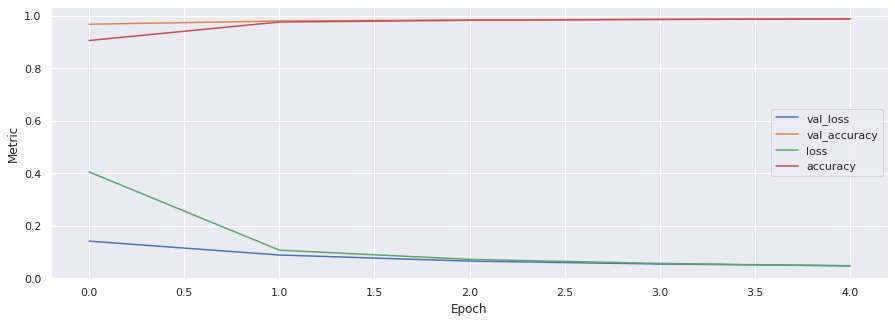

In [16]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
history_df.plot(ax=ax)
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

# Evaluate

In [17]:
print('\n# Evaluate on test data')
results = classifier.evaluate(train_x, train_y)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
4000/4000 [==============================] - 9s 2ms/step
loss: 0.04187693138420582
accuracy: 0.9892399907112122


## Confusion Matrix

In [18]:
def remap(matrix):
    """
    Utility function to take one-hot encoded labels and return the label with the higest probability
    """
    
    #Switch index to label
    def switcher(x):
        return dummyIndex_label_dict[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

In [20]:
#Get the predicted classes for the test set
prediction_probabilities = classifier.predict(test_x)

predicted_classes = remap(prediction_probabilities)
true_classes = remap(test_y)

In [21]:
# Unravel it
predicted_classes = predicted_classes.values.reshape(-1,1)
true_classes = true_classes.values.reshape(-1,1)

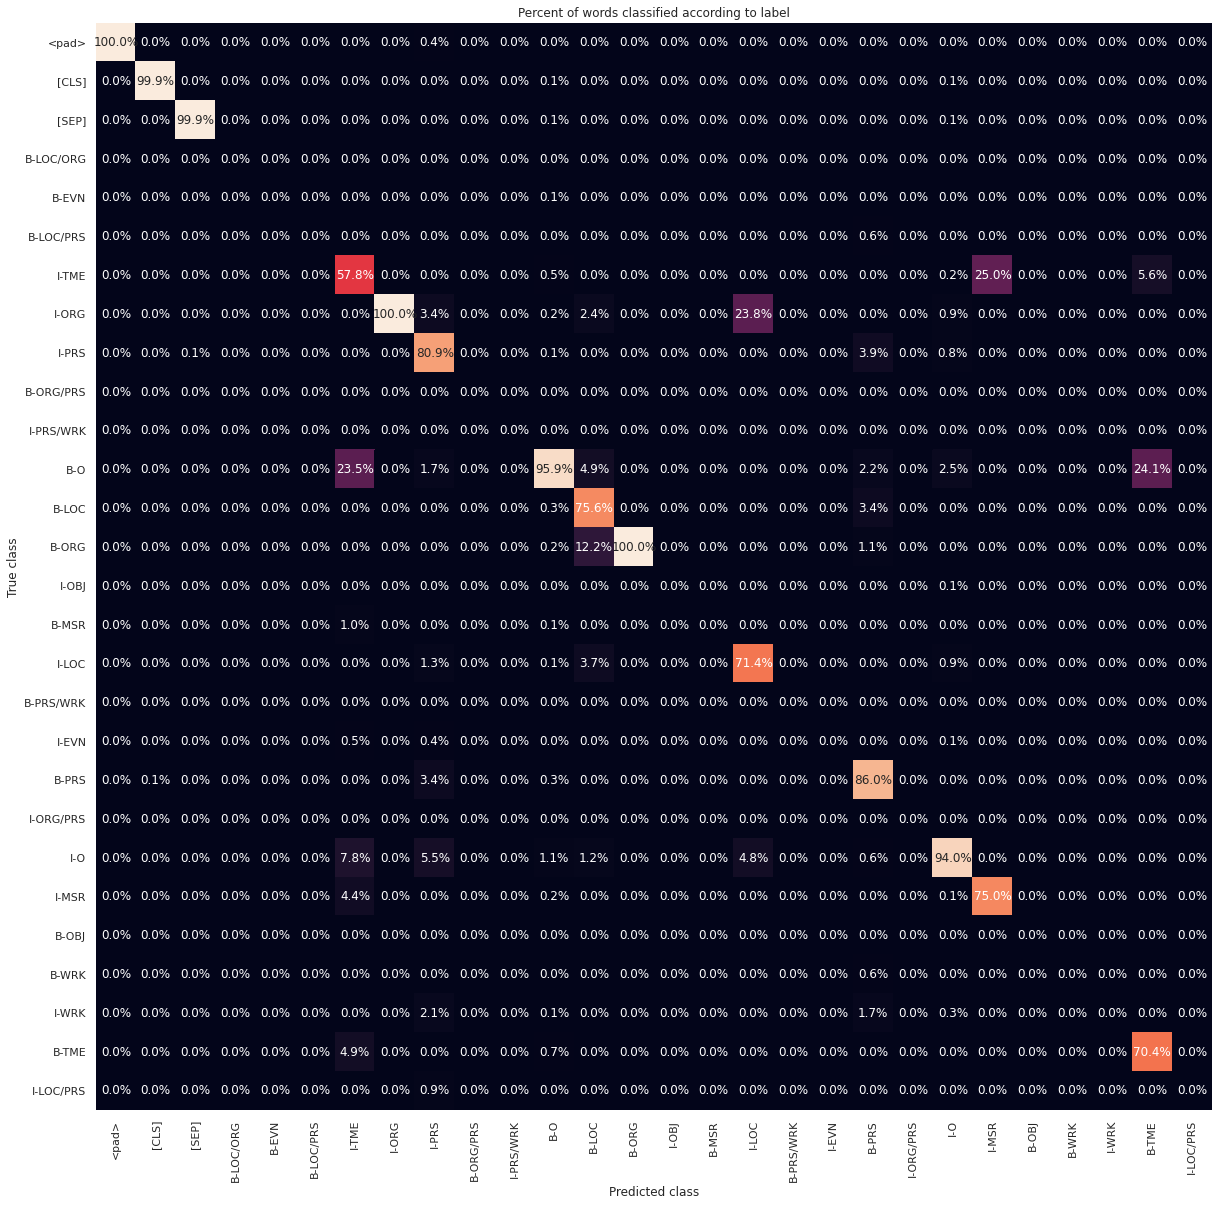

In [27]:
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
cf_labels = list(dummyIndex_label_dict.values())

# We are great at padding, but that isn't super-interesting
#labels.remove('<pad>')

#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=cf_labels, index=cf_labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 0)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Percent of words classified according to label")
plt.show()

## Generate Recall, Precision, F1-score for each label

In [28]:
from sklearn.metrics import classification_report

report = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels, output_dict=True, zero_division=0)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
<pad>,0.999617,0.999974,0.999796,78383.0
[CLS],0.998989,0.988000,0.993464,1000.0
[SEP],0.998973,0.973974,0.986315,999.0
B-LOC/ORG,0.000000,0.000000,0.000000,0.0
B-EVN,0.000000,0.000000,0.000000,9.0
B-LOC/PRS,0.000000,0.000000,0.000000,2.0
I-TME,0.578431,0.590000,0.584158,200.0
I-ORG,1.000000,0.077778,0.144330,90.0
I-PRS,0.808511,0.785124,0.796646,242.0
B-ORG/PRS,0.000000,0.000000,0.000000,0.0


## Test albert and classifier on single sentences

In [29]:
def format_single_sentence(s):
    """
    Takes a string and formats it for use with the ALBERT model used in this project
    Also returns the attention mask
    """
    pad_symbol = tokenizer.encode('<pad>', add_special_tokens=False)
    input_array = pad_symbol*100

    # Encode our sentence
    encoding = tokenizer.encode(s)

    #Overwrite our dummy array
    input_array[:len(encoding)] = encoding

    #Adjust dimensionality, make it a tensor
    input_tensor = torch.tensor(np.array(input_array).reshape(1,-1))
    
    attention = np.array(input_array) != 0
    attention_tensor = torch.tensor(attention.reshape(1,-1))
    return input_tensor, attention_tensor
    
#inp, att = format_single_sentence('hi')

In [30]:
def classify_single_sentence(sentence_tensor, attention_tensor):
    """
    Given input formatted for use with the ALBERT model, generates embeddings and uses them with a classifier to generate prediction for each original word
    Returns a dataframe containing token, predicted token, and certainity/probability
    """
    embedding = get_embeddings_with_gpu_batch(sentence_tensor, attention_tensor, 1)
    
    #Predict using the embeddings
    prediction_probabilities = classifier.predict(embedding)

    #Given these probabilities, get the predicted class for each word
    predicted_labels = remap(prediction_probabilities)

    #Get the confidence for our predictions as well
    certainity = prediction_probabilities.max(axis=2)

    #Get the input token array we used
    sentence_tokens = tokenizer.convert_ids_to_tokens(np.array(sentence_tensor).reshape(-1,))

    #Put it all into a dataframe for an easy-to-read output
    pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'Certainity'])

    pretty_df['Word'] = sentence_tokens
    pretty_df['Predicted_Label'] = predicted_labels.T
    pretty_df['Certainity'] = certainity.T
    
    return pretty_df

In [31]:
def NER(sentence):
    """
    Shorthand function for taken any sentence and tesing the model/classifier on it
    """
    sentence_tensor, attention_tensor = format_single_sentence(sentence)
    results = classify_single_sentence(sentence_tensor, attention_tensor)
    return results

In [33]:
s = "Jim är en student på KTH sedan 2020, han studerar i Stockholm och arbetar med bioteknik."
s = ""

NER(s).head(20)

100%|██████████| 1/1 [00:00<00:00, 27.17it/s]

Final embedding generated with shape (1, 100, 768)


,Word,Predicted_Label,Certainity
0,[CLS],[CLS],0.988186
1,▁Jim,B-PRS,0.774892
2,▁är,B-O,0.935705
3,▁en,B-O,0.968585
4,▁student,B-O,0.958491
5,▁på,B-O,0.824784
6,▁KTH,B-LOC,0.381393
7,▁sedan,B-TME,0.668536
8,▁2020,I-TME,0.707608
9,",",B-O,0.811044


## Test on sentence from SUC

In [39]:
#Select a sentence
select = 4999

# Get the original sentence
sentence = np.array(sentences[select])
sentence_tokens = np.array(tokenizer.convert_ids_to_tokens(sentence))

# Get the ground truth labels
one_hot_truth = label_matrix[select].reshape(1,100,-1)
gt_labels = remap(one_hot_truth)

#Get the embedding matrix we generated for the sentence
sentence_embedding = embedding_matrix[select].reshape(1,100,-1)

#For each word, obtain the probabilities for each class
prediction_probabilities = classifier.predict(sentence_embedding)

#Given these probabilities, get the predicted class for each word
predicted_labels = remap(prediction_probabilities)

#Get the confidence for our predictions as well
certainity = prediction_probabilities.max(axis=2)


#Put it all into a dataframe for an easy-to-read output
pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'True_Label', 'Certainity'])

pretty_df['Word'] = sentence_tokens
pretty_df['Predicted_Label'] = predicted_labels.T
pretty_df['True_Label'] = gt_labels.T
pretty_df['Certainity'] = certainity.T


pretty_df.head(20)

,Word,Predicted_Label,True_Label,Certainity
0,[CLS],[CLS],[CLS],0.993821
1,▁,B-O,B-O,0.876204
2,-,I-O,I-O,0.928279
3,▁Under,B-TME,B-O,0.477191
4,▁denna,B-O,B-O,0.655890
5,▁mässa,B-O,B-O,0.632979
6,▁tog,B-O,B-O,0.972610
7,▁vi,B-O,B-O,0.995264
8,▁på,B-O,B-O,0.973143
9,▁oss,B-O,B-O,0.995951


In [ ]:
# Randomize train test split?

# A good read on using the fine-tuning approach
# https://medium.com/swlh/named-entity-recognition-using-bert-2fb924864d47